## Import Packages

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
from scipy.optimize import minimize

from utils_file.tools import load_cache_file
from utils_file.finance_tools import *

warnings.filterwarnings("ignore")
path = "figure_file"

## Load Data

In [2]:
static_pt = load_cache_file("data_file/static_strategy/ap_reward_result_test.pkl")

dqn_pt = load_cache_file("pre-train-fixWindow/test_result_119.pkl")
dqn_pt_reward = list(dqn_pt["reward_result"].values())

## Comparison Target: Reduced S&P 500 Constituent

In [3]:
test_data_reduced = pd.read_csv("data_file/test_PT.csv", encoding="UTF-8")
tickers_reduced = test_data_reduced["Ticker"].unique()

In [4]:
# Add daily log return and Bollinger bands to the original stock price data
append_value_reduced = []

for ticker in tickers_reduced:
    target = test_data_reduced[test_data_reduced["Ticker"] == ticker].copy()
    target["ma_line"] = target["Close"].rolling(window=5).mean()
    std = target["Close"].rolling(window=5).std()
    target["upper_bound"] = target["ma_line"] + 1 * std
    target["lower_bound"] = target["ma_line"] - 1 * std

    target["log_return"] = np.log(target["Close"] / target["Close"].shift(1))

    target = target.dropna()
    append_value_reduced.append(target)

test_append_reduced = pd.concat(append_value_reduced, ignore_index=True)

In [5]:
# Divide the stock price data of individual stocks according to each month
split_test_reduced = {}

unique_years = test_append_reduced["Year"].unique()
unique_months = test_append_reduced["Month"].unique()

idx = 1
for year in unique_years:
    for month in unique_months:
        split_test_reduced[f"state_{idx}"] = {}
        mask_table = test_append_reduced[
            (test_append_reduced["Year"] == year) & (test_append_reduced["Month"] == month)
        ]

        for ticker in tickers_reduced:
            split_test_reduced[f"state_{idx}"][ticker] = mask_table[
                mask_table["Ticker"] == ticker
            ].copy()

        idx += 1

### Strategy: Buy and Hold

In [6]:
single_result_reduced_BandH = {}

for state in list(split_test_reduced.keys()):
    all_ticker_reward = []

    for ticker in tickers_reduced:
        all_ticker_reward.append(split_test_reduced[state][ticker]["log_return"].sum())

    single_result_reduced_BandH[state] = all_ticker_reward

In [7]:
single_result_reduced_BandH_table = pd.DataFrame(single_result_reduced_BandH, index=tickers_reduced)

static_pt_table = pd.DataFrame(static_pt).T

### Strategy: Bollinger Bands

In [8]:
# Each component stock executes a Bollinger Band trading strategy
single_result_reduced_BB = {}

for state in list(split_test_reduced.keys()):
    all_ticker_reward = []

    for ticker in tickers_reduced:
        temp = split_test_reduced[state][ticker]

        ub_open_flag = False
        lb_open_flag = False
        status_list = []

        for i, row in temp.iterrows():
            if row["Close"] > row["upper_bound"] and ub_open_flag is False:
                status_list.append("UB_open")
                ub_open_flag = True

            elif row["Close"] < row["ma_line"] and ub_open_flag is True:
                status_list.append("UB_close")
                ub_open_flag = False

            elif row["Close"] < row["lower_bound"] and lb_open_flag is False:
                status_list.append("LB_open")
                lb_open_flag = True

            elif row["Close"] > row["ma_line"] and lb_open_flag is True:
                status_list.append("LB_close")
                lb_open_flag = False

            else:
                status_list.append(0)

        status_list[-1] = "close"
        temp["status"] = status_list

        reward_record = []
        UB_price = None
        LB_price = None

        for i, row in temp.iterrows():
            if row["status"] == "UB_open" and UB_price is None:
                UB_price = row["Close"]

            elif row["status"] == "LB_open" and LB_price is None:
                LB_price = row["Close"]

            elif row["status"] == "UB_close" and UB_price is not None:
                simple_return = (row["Close"] - UB_price) / UB_price
                reward_record.append(simple_return)
                UB_price = None

            elif row["status"] == "LB_close" and LB_price is not None:
                simple_return = -(row["Close"] - LB_price) / LB_price
                reward_record.append(simple_return)
                LB_price = None

            elif row["status"] == "close" and UB_price is not None:
                simple_return = (row["Close"] - UB_price) / UB_price
                reward_record.append(simple_return)

            elif row["status"] == "close" and LB_price is not None:
                simple_return = -(row["Close"] - LB_price) / LB_price
                reward_record.append(simple_return)

        all_ticker_reward.append(sum(reward_record))

    single_result_reduced_BB[state] = all_ticker_reward

In [9]:
single_result_reduced_BB_table = pd.DataFrame(single_result_reduced_BB, index=tickers_reduced)

### Boxplot for rewards

In [13]:
single_result_reduced_BandH_table.columns = static_pt_table.columns  # adjust the column name

plot_data_merge_reduced_BandH = pd.concat([static_pt_table, single_result_reduced_BandH_table], axis=0)
plot_data_merge_reduced_BandH["type"] = ["Static PT"] * len(static_pt_table) + [
    "Single Assets"
] * len(single_result_reduced_BandH_table)

plot_data_merge_reduced_BandH = plot_data_merge_reduced_BandH.melt(
    id_vars="type", var_name="time", value_name="value"
)
plot_data_merge_reduced_BandH["time"] = plot_data_merge_reduced_BandH["time"] + 1

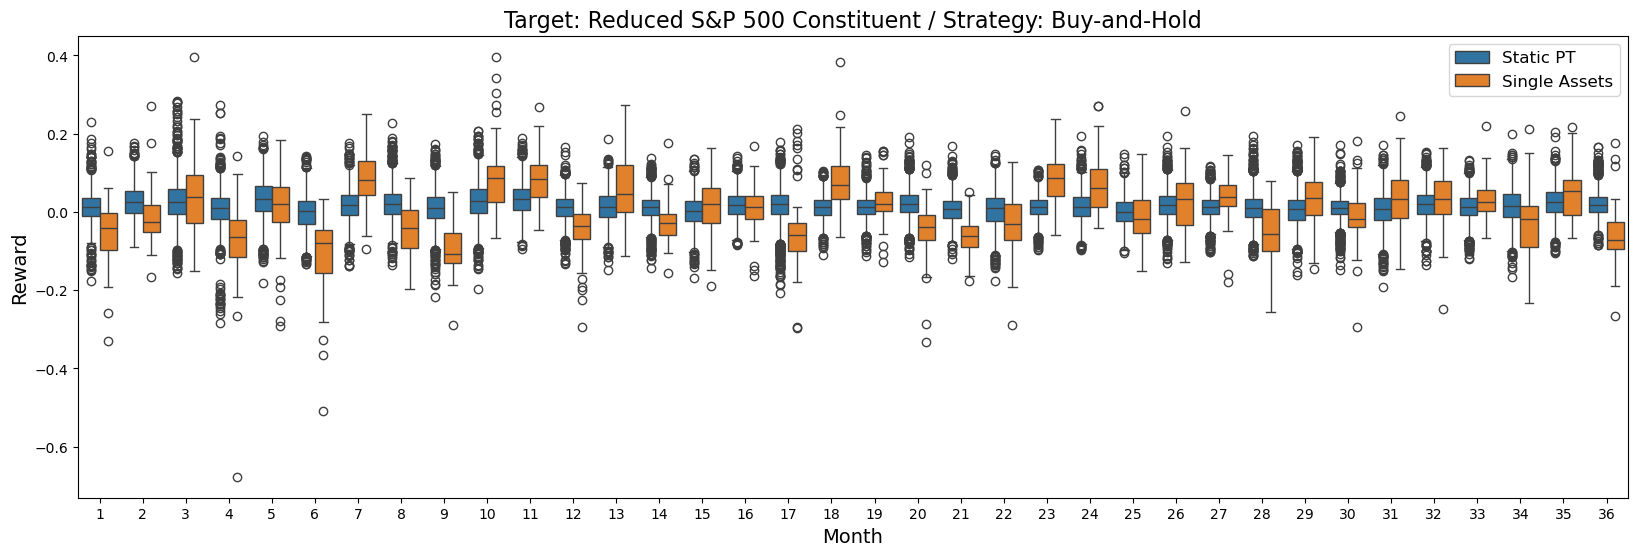

In [14]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=plot_data_merge_reduced_BandH, x="time", y="value", hue="type")
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend(fontsize=12)
plt.title("Target: Reduced S&P 500 Constituent / Strategy: Buy-and-Hold", fontsize=16)
plt.savefig(f"{path}/reduced_BandH_vs_staticPT.png", dpi=300, bbox_inches="tight")
plt.show()

In [15]:
single_result_reduced_BB_table.columns = static_pt_table.columns  # adjust the column name

plot_data_merge_reduced_BB = pd.concat([static_pt_table, single_result_reduced_BB_table], axis=0)
plot_data_merge_reduced_BB["type"] = ["Static PT"] * len(static_pt_table) + [
    "Single Assets"
] * len(single_result_reduced_BB_table)

plot_data_merge_reduced_BB = plot_data_merge_reduced_BB.melt(
    id_vars="type", var_name="time", value_name="value"
)
plot_data_merge_reduced_BB["time"] = plot_data_merge_reduced_BB["time"] + 1

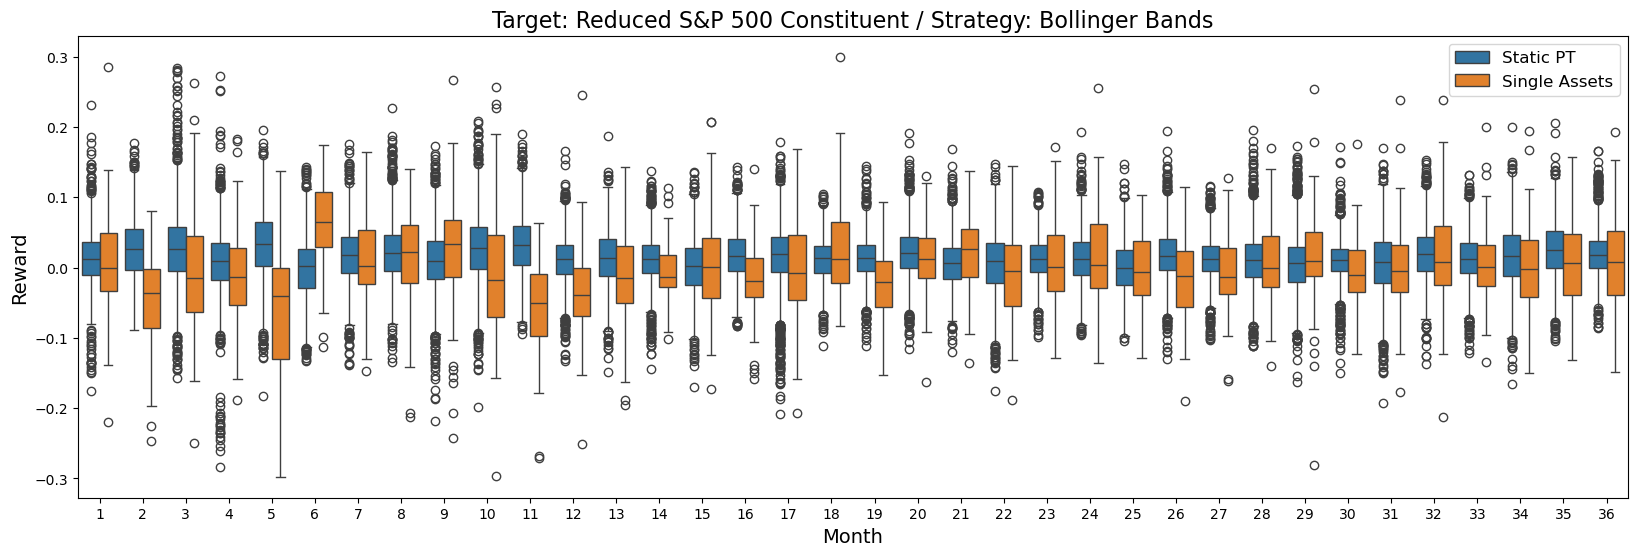

In [16]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=plot_data_merge_reduced_BB, x="time", y="value", hue="type")
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend(fontsize=12)
plt.title("Target: Reduced S&P 500 Constituent / Strategy: Bollinger Bands", fontsize=16)
plt.savefig(f"{path}/reduced_BB_vs_staticPT.png", dpi=300, bbox_inches="tight")
plt.show()

In [17]:
above_median_x_reduced_BandH, above_median_y_reduced_BandH = [], []
below_median_x_reduced_BandH, below_median_y_reduced_BandH = [], []

for x, y in enumerate(single_result_reduced_BandH_table.median()):
    value = dqn_pt_reward[x]

    if value > y:
        above_median_x_reduced_BandH.append(x + 1)
        above_median_y_reduced_BandH.append(value)

    else:
        below_median_x_reduced_BandH.append(x + 1)
        below_median_y_reduced_BandH.append(value)

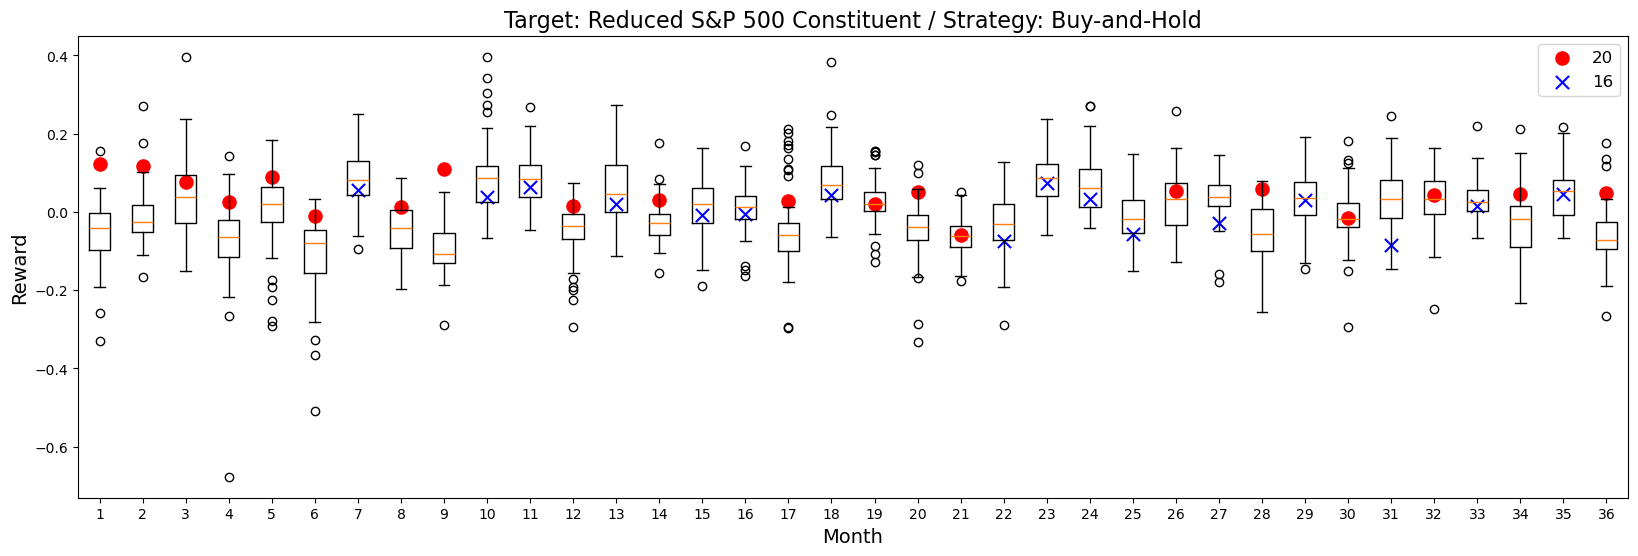

In [18]:
plt.figure(figsize=(20, 6))
plt.boxplot(single_result_reduced_BandH_table)
plt.scatter(
    above_median_x_reduced_BandH,
    above_median_y_reduced_BandH,
    s=90,
    color="red",
    marker="o",
    label=f"{len(above_median_x_reduced_BandH)}",
)
plt.scatter(
    below_median_x_reduced_BandH,
    below_median_y_reduced_BandH,
    s=90,
    color="blue",
    marker="x",
    label=f"{len(below_median_x_reduced_BandH)}",
)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend(fontsize=12)
plt.title("Target: Reduced S&P 500 Constituent / Strategy: Buy-and-Hold", fontsize=16)
plt.savefig(f"{path}/reduced_BandH_vs_DQNPT.png", dpi=300, bbox_inches="tight")
plt.show()

In [19]:
above_median_x_reduced_BB, above_median_y_reduced_BB = [], []
below_median_x_reduced_BB, below_median_y_reduced_BB = [], []

for x, y in enumerate(single_result_reduced_BB_table.median()):
    value = dqn_pt_reward[x]

    if value > y:
        above_median_x_reduced_BB.append(x + 1)
        above_median_y_reduced_BB.append(value)

    else:
        below_median_x_reduced_BB.append(x + 1)
        below_median_y_reduced_BB.append(value)

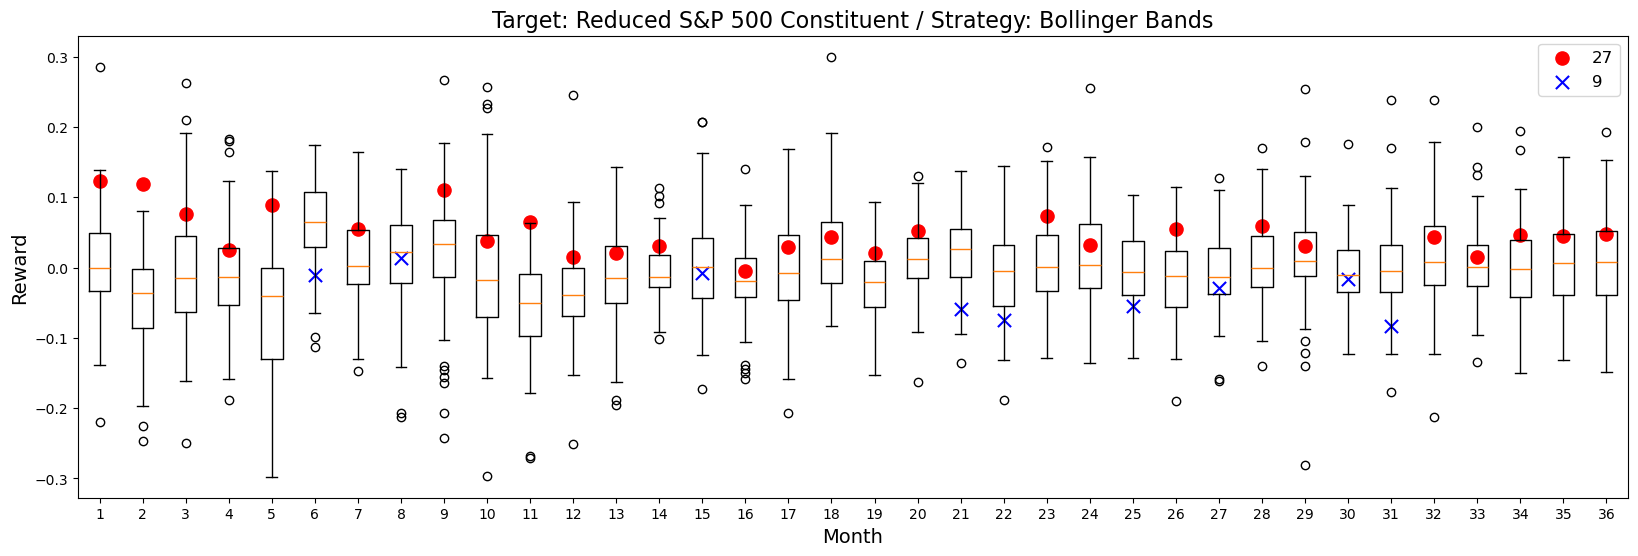

In [20]:
plt.figure(figsize=(20, 6))
plt.boxplot(single_result_reduced_BB_table)
plt.scatter(
    above_median_x_reduced_BB,
    above_median_y_reduced_BB,
    s=90,
    color="red",
    marker="o",
    label=f"{len(above_median_x_reduced_BB)}",
)
plt.scatter(
    below_median_x_reduced_BB,
    below_median_y_reduced_BB,
    s=90,
    color="blue",
    marker="x",
    label=f"{len(below_median_x_reduced_BB)}",
)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend(fontsize=12)
plt.title("Target: Reduced S&P 500 Constituent / Strategy: Bollinger Bands", fontsize=16)
plt.savefig(f"{path}/reduced_BB_vs_DQNPT.png", dpi=300, bbox_inches="tight")
plt.show()

### WRS test for median

In [23]:
static_pt_median = static_pt_table.median(axis=0)
single_median_reduced_BandH = single_result_reduced_BandH_table.median(axis=0)

statistic, pvalue = wilcoxon(
    static_pt_median, single_median_reduced_BandH, alternative="greater"
)
print(f"p-value of WRS test (Static-PT vs. Reduced S&P 500 (B&H) ): {pvalue: .4f}")

print("=" * 30)

statistic, pvalue = wilcoxon(
    dqn_pt_reward, single_median_reduced_BandH, alternative="greater"
)
print(f"p-value of WRS test (DQN-PT vs. Reduced S&P 500 (B&H) ): {pvalue: .4f}")

p-value of WRS test (Static-PT vs. Reduced S&P 500 (B&H) ):  0.0881
p-value of WRS test (DQN-PT vs. Reduced S&P 500 (B&H) ):  0.0457


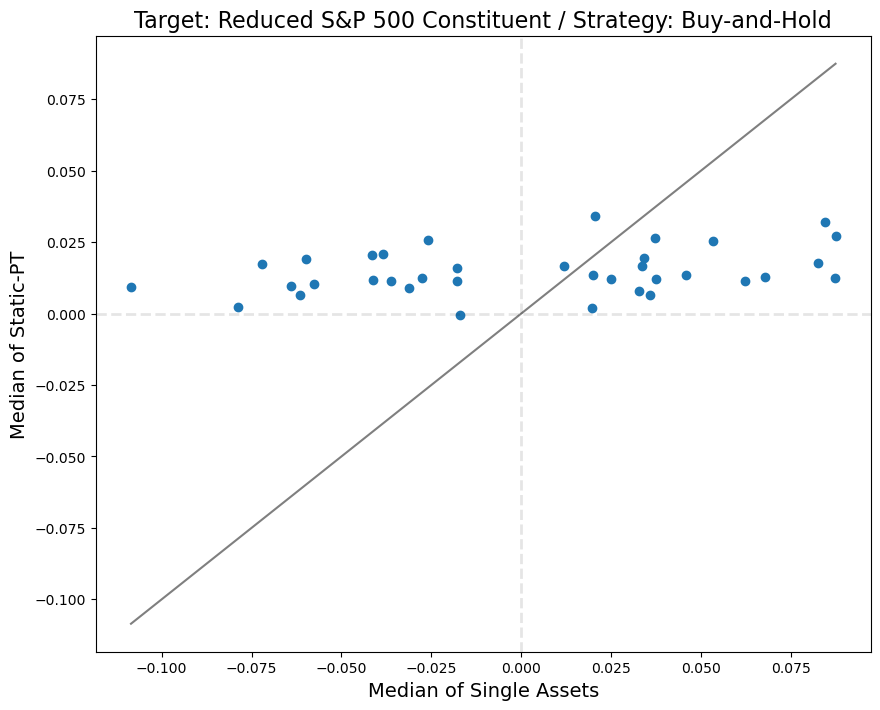

In [26]:
plt.figure(figsize=(10, 8))
plt.scatter(single_median_reduced_BandH, static_pt_median)
plt.plot(
    np.linspace(
        min(min(single_median_reduced_BandH), min(static_pt_median)),
        max(max(single_median_reduced_BandH), max(static_pt_median)),
        200,
    ),
    np.linspace(
        min(min(single_median_reduced_BandH), min(static_pt_median)),
        max(max(single_median_reduced_BandH), max(static_pt_median)),
        200,
    ),
    color="black",
    alpha=0.5,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Median of Single Assets", fontsize=14)
plt.ylabel("Median of Static-PT", fontsize=14)
plt.title("Target: Reduced S&P 500 Constituent / Strategy: Buy-and-Hold", fontsize=16)
plt.savefig(f"{path}/reduced_BandH_vs_staticPT_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

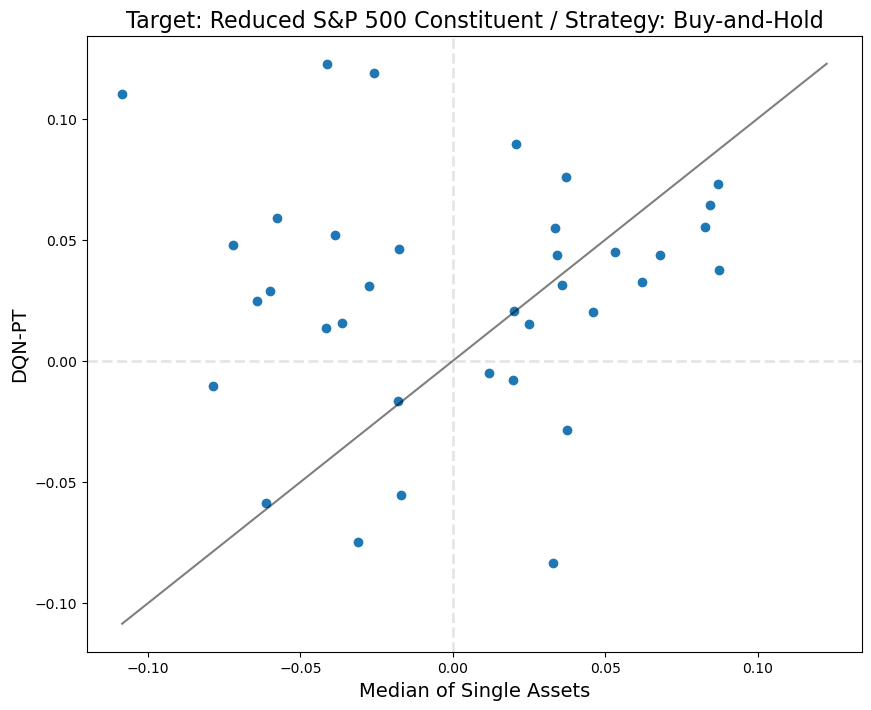

In [31]:
plt.figure(figsize=(10, 8))
plt.scatter(single_median_reduced_BandH, dqn_pt_reward)
plt.plot(
    np.linspace(
        min(min(single_median_reduced_BandH), min(dqn_pt_reward)),
        max(max(single_median_reduced_BandH), max(dqn_pt_reward)),
        200,
    ),
    np.linspace(
        min(min(single_median_reduced_BandH), min(dqn_pt_reward)),
        max(max(single_median_reduced_BandH), max(dqn_pt_reward)),
        200,
    ),
    color="black",
    alpha=0.5,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Median of Single Assets", fontsize=14)
plt.ylabel("DQN-PT", fontsize=14)
plt.title("Target: Reduced S&P 500 Constituent / Strategy: Buy-and-Hold", fontsize=16)
plt.savefig(f"{path}/reduced_BandH_vs_DQNPT_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

In [30]:
single_median_reduced_BB = single_result_reduced_BB_table.median(axis=0)

statistic, pvalue = wilcoxon(
    static_pt_median, single_median_reduced_BB, alternative="greater"
)
print(f"p-value of WRS test (Static-PT vs. Reduced S&P 500 (BB) ): {pvalue: .4f}")

print("=" * 30)

statistic, pvalue = wilcoxon(dqn_pt_reward, single_median_reduced_BB, alternative="greater")
print(f"p-value of WRS test (DQN-PT vs. Reduced S&P 500 (BB) ): {pvalue: .4f}")

p-value of WRS test (Static-PT vs. Reduced S&P 500 (BB) ):  0.0000
p-value of WRS test (DQN-PT vs. Reduced S&P 500 (BB) ):  0.0013


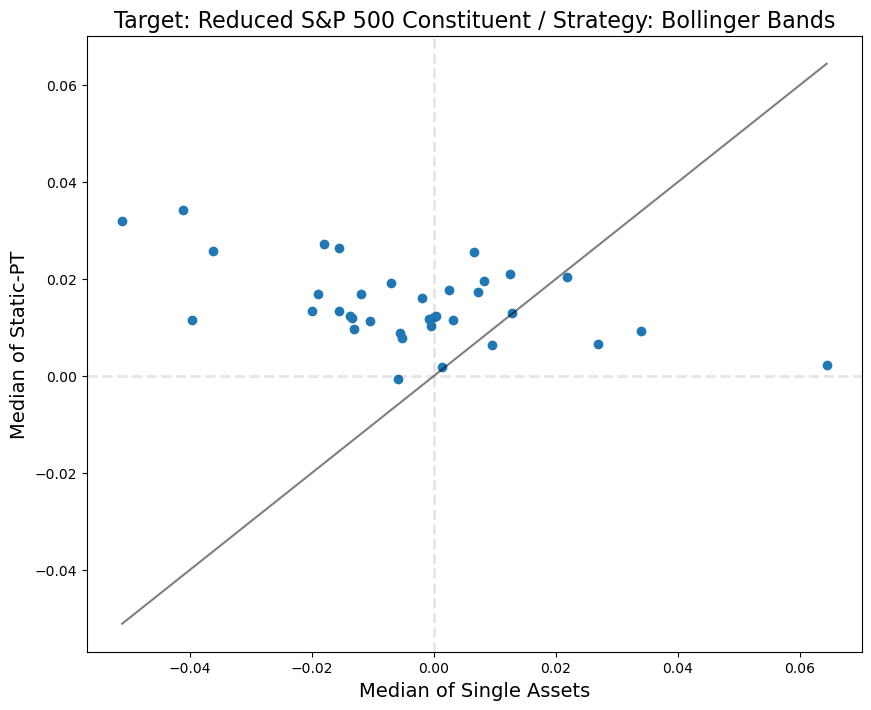

In [32]:
plt.figure(figsize=(10, 8))
plt.scatter(single_median_reduced_BB, static_pt_median)
plt.plot(
    np.linspace(
        min(min(single_median_reduced_BB), min(static_pt_median)),
        max(max(single_median_reduced_BB), max(static_pt_median)),
        200,
    ),
    np.linspace(
        min(min(single_median_reduced_BB), min(static_pt_median)),
        max(max(single_median_reduced_BB), max(static_pt_median)),
        200,
    ),
    color="black",
    alpha=0.5,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Median of Single Assets", fontsize=14)
plt.ylabel("Median of Static-PT", fontsize=14)
plt.title("Target: Reduced S&P 500 Constituent / Strategy: Bollinger Bands", fontsize=16)
plt.savefig(f"{path}/reduced_BB_vs_StaticPT_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

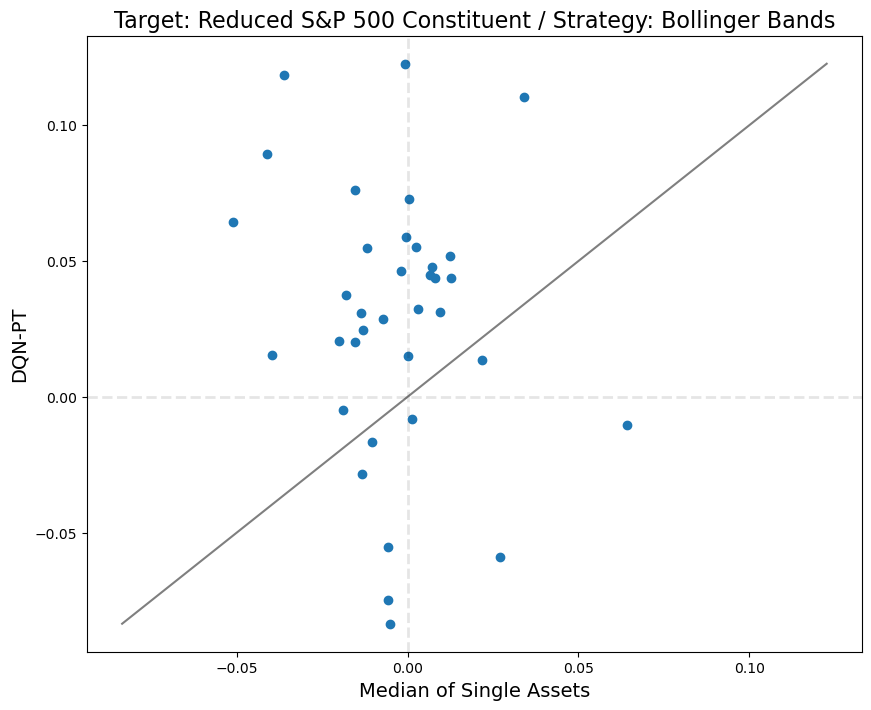

In [34]:
plt.figure(figsize=(10, 8))
plt.scatter(single_median_reduced_BB, dqn_pt_reward)
plt.plot(
    np.linspace(
        min(min(single_median_reduced_BB), min(dqn_pt_reward)),
        max(max(single_median_reduced_BB), max(dqn_pt_reward)),
        200,
    ),
    np.linspace(
        min(min(single_median_reduced_BB), min(dqn_pt_reward)),
        max(max(single_median_reduced_BB), max(dqn_pt_reward)),
        200,
    ),
    color="black",
    alpha=0.5,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Median of Single Assets", fontsize=14)
plt.ylabel("DQN-PT", fontsize=14)
plt.title("Target: Reduced S&P 500 Constituent / Strategy: Bollinger Bands", fontsize=16)
plt.savefig(f"{path}/reduced_BB_vs_DQNPT_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

## Comparison Target: Total S&P 500 Constituent

In [35]:
test_data_total = pd.read_csv("data_file/test.csv", encoding="UTF-8")
tickers_total = test_data_total["Ticker"].unique()

In [36]:
# Add daily log return and Bollinger bands to the original stock price data
append_value_total = []

for ticker in tickers_total:
    target = test_data_total[test_data_total["Ticker"] == ticker].copy()
    target["ma_line"] = target["Close"].rolling(window=5).mean()
    std = target["Close"].rolling(window=5).std()
    target["upper_bound"] = target["ma_line"] + 1 * std
    target["lower_bound"] = target["ma_line"] - 1 * std

    target["log_return"] = np.log(target["Close"] / target["Close"].shift(1))

    target = target.dropna()
    append_value_total.append(target)

test_append_total = pd.concat(append_value_total, ignore_index=True)

In [37]:
# Divide the stock price data of individual stocks according to each month
split_test_total = {}

unique_years_total = test_append_total["Year"].unique()
unique_months_total = test_append_total["Month"].unique()

idx = 1
for year in unique_years_total:
    for month in unique_months_total:
        split_test_total[f"state_{idx}"] = {}
        mask_table = test_append_total[
            (test_append_total["Year"] == year) & (test_append_total["Month"] == month)
        ]

        for ticker in tickers_total:
            split_test_total[f"state_{idx}"][ticker] = mask_table[
                mask_table["Ticker"] == ticker
            ].copy()

        idx += 1

### Strategy: Buy and Hold

In [38]:
single_result_total_BandH = {}

for state in list(split_test_total.keys()):
    all_ticker_reward_total = []

    for ticker in tickers_total:
        all_ticker_reward_total.append(
            split_test_total[state][ticker]["log_return"].sum()
        )

    single_result_total_BandH[state] = all_ticker_reward_total

In [39]:
single_result_total_BandH_table = pd.DataFrame(
    single_result_total_BandH, index=tickers_total
)

### Strategy: Bollinger Bands

In [40]:
# Each component stock executes a Bollinger Band trading strategy
single_result_total_BB = {}

for state in list(split_test_total.keys()):
    all_ticker_reward_total = []

    for ticker in tickers_total:
        temp = split_test_total[state][ticker]

        ub_open_flag = False
        lb_open_flag = False
        status_list = []

        for i, row in temp.iterrows():
            if row["Close"] > row["upper_bound"] and ub_open_flag is False:
                status_list.append("UB_open")
                ub_open_flag = True

            elif row["Close"] < row["ma_line"] and ub_open_flag is True:
                status_list.append("UB_close")
                ub_open_flag = False

            elif row["Close"] < row["lower_bound"] and lb_open_flag is False:
                status_list.append("LB_open")
                lb_open_flag = True

            elif row["Close"] > row["ma_line"] and lb_open_flag is True:
                status_list.append("LB_close")
                lb_open_flag = False

            else:
                status_list.append(0)

        status_list[-1] = "close"
        temp["status"] = status_list

        reward_record = []
        UB_price = None
        LB_price = None

        for i, row in temp.iterrows():
            if row["status"] == "UB_open" and UB_price is None:
                UB_price = row["Close"]

            elif row["status"] == "LB_open" and LB_price is None:
                LB_price = row["Close"]

            elif row["status"] == "UB_close" and UB_price is not None:
                simple_return = (row["Close"] - UB_price) / UB_price
                reward_record.append(simple_return)
                UB_price = None

            elif row["status"] == "LB_close" and LB_price is not None:
                simple_return = -(row["Close"] - LB_price) / LB_price
                reward_record.append(simple_return)
                LB_price = None

            elif row["status"] == "close" and UB_price is not None:
                simple_return = (row["Close"] - UB_price) / UB_price
                reward_record.append(simple_return)

            elif row["status"] == "close" and LB_price is not None:
                simple_return = -(row["Close"] - LB_price) / LB_price
                reward_record.append(simple_return)

        all_ticker_reward_total.append(sum(reward_record))

    single_result_total_BB[state] = all_ticker_reward_total

In [41]:
single_result_total_BB_table = pd.DataFrame(single_result_total_BB, index=tickers_total)

In [42]:
single_result_total_BandH_table.columns = (
    static_pt_table.columns
)  # adjust the column name

plot_data_merge_total_BandH = pd.concat(
    [static_pt_table, single_result_total_BandH_table], axis=0
)
plot_data_merge_total_BandH["type"] = ["Static PT"] * len(static_pt_table) + [
    "Single Assets"
] * len(single_result_total_BandH_table)

plot_data_merge_total_BandH = plot_data_merge_total_BandH.melt(
    id_vars="type", var_name="time", value_name="value"
)
plot_data_merge_total_BandH["time"] = plot_data_merge_total_BandH["time"] + 1

### Boxplot for rewards

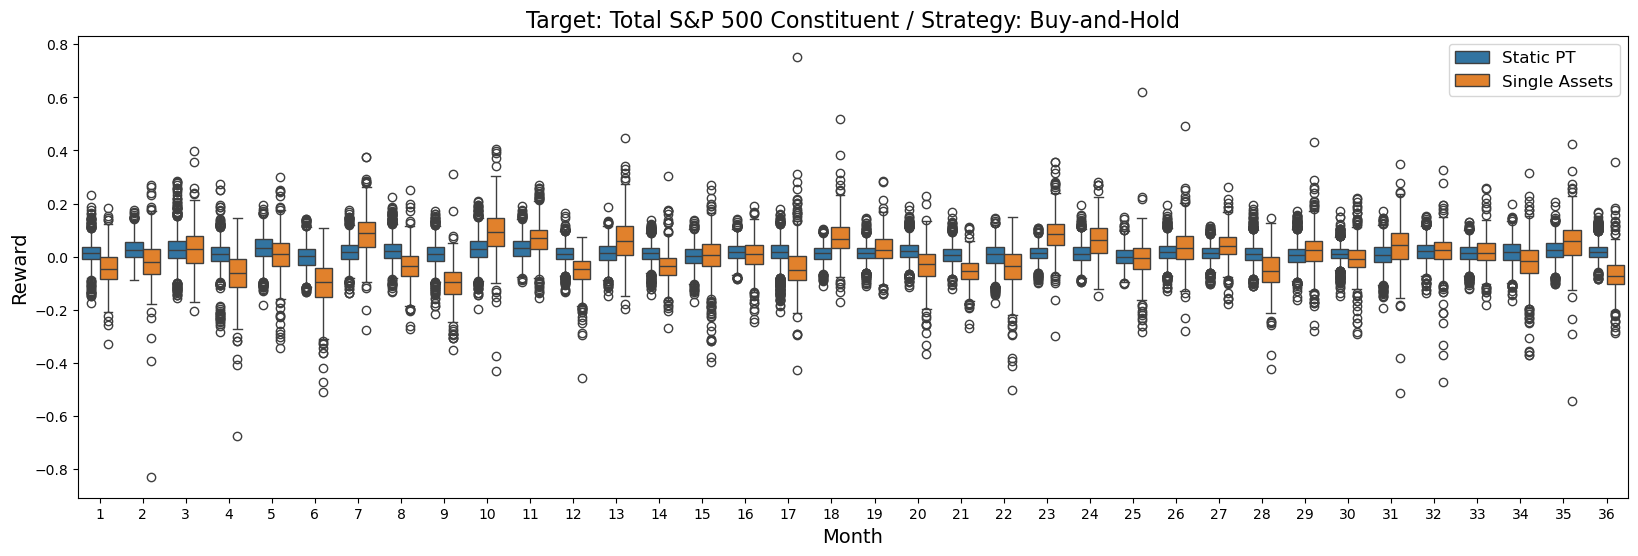

In [43]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=plot_data_merge_total_BandH, x="time", y="value", hue="type")
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend(fontsize=12)
plt.title("Target: Total S&P 500 Constituent / Strategy: Buy-and-Hold", fontsize=16)
plt.savefig(f"{path}/total_BandH_vs_StaticPT.png", dpi=300, bbox_inches="tight")
plt.show()

In [44]:
single_result_total_BB_table.columns = (
    static_pt_table.columns
)  # adjust the column name

plot_data_merge_total_BB = pd.concat(
    [static_pt_table, single_result_total_BB_table], axis=0
)
plot_data_merge_total_BB["type"] = ["Static PT"] * len(static_pt_table) + [
    "Single Assets"
] * len(single_result_total_BB_table)

plot_data_merge_total_BB = plot_data_merge_total_BB.melt(
    id_vars="type", var_name="time", value_name="value"
)
plot_data_merge_total_BB["time"] = plot_data_merge_total_BB["time"] + 1

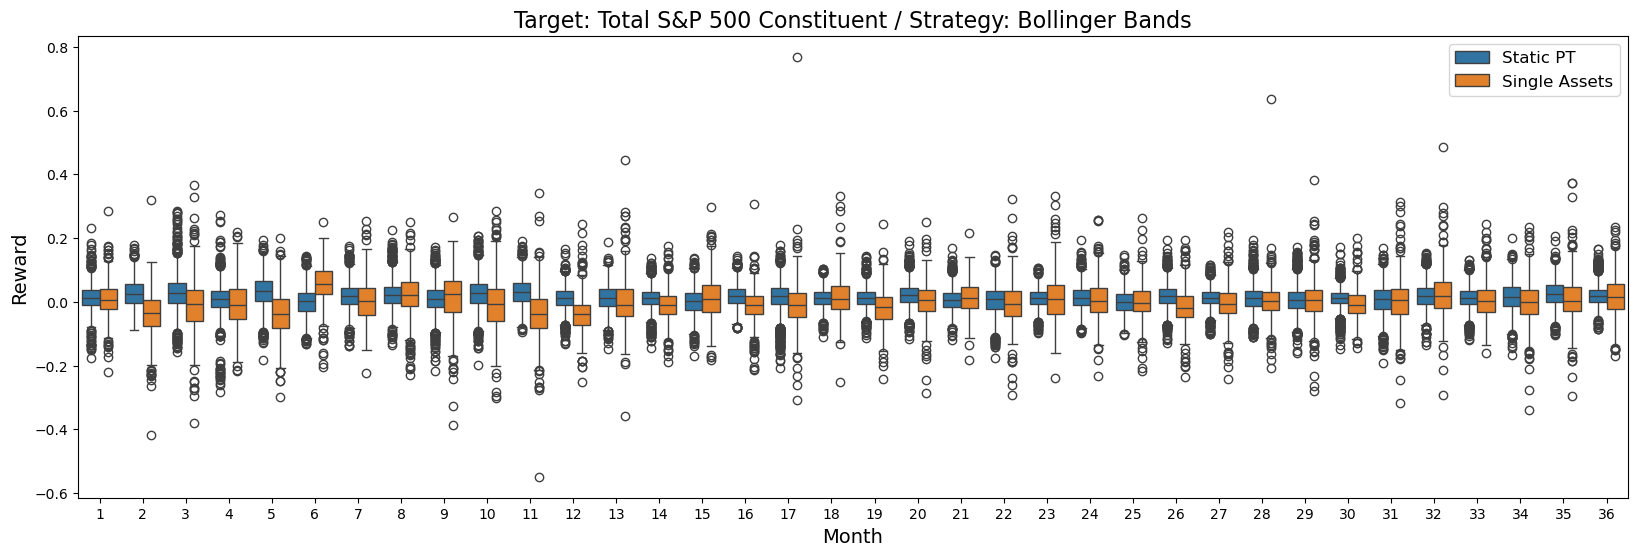

In [45]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=plot_data_merge_total_BB, x="time", y="value", hue="type")
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend(fontsize=12)
plt.title("Target: Total S&P 500 Constituent / Strategy: Bollinger Bands", fontsize=16)
plt.savefig(f"{path}/total_BB_vs_StaticPT.png", dpi=300, bbox_inches="tight")
plt.show()

In [58]:
above_median_x_total_BandH, above_median_y_total_BandH = [], []
below_median_x_total_BandH, below_median_y_total_BandH = [], []

for x, y in enumerate(single_result_total_BandH_table.median()):
    value = dqn_pt_reward[x]

    if value > y:
        above_median_x_total_BandH.append(x + 1)
        above_median_y_total_BandH.append(value)

    else:
        below_median_x_total_BandH.append(x + 1)
        below_median_y_total_BandH.append(value)

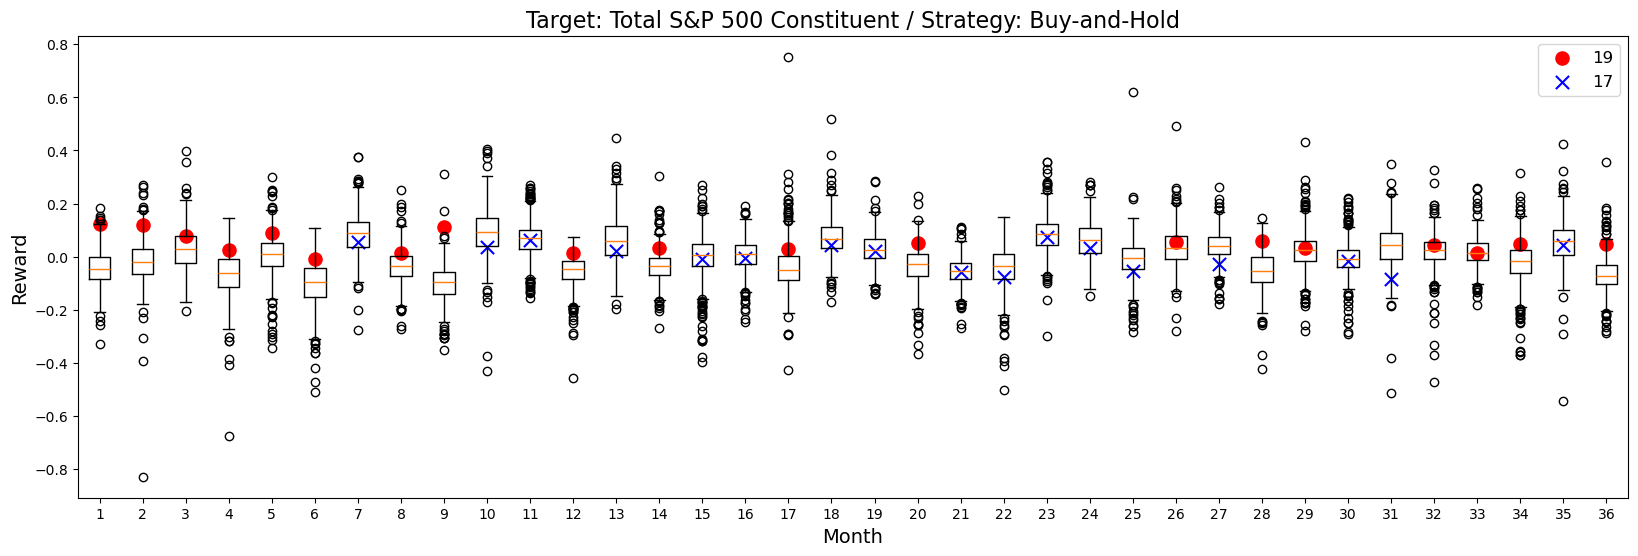

In [59]:
plt.figure(figsize=(20, 6))
plt.boxplot(single_result_total_BandH_table)
plt.scatter(
    above_median_x_total_BandH,
    above_median_y_total_BandH,
    s=90,
    color="red",
    marker="o",
    label=f"{len(above_median_x_total_BandH)}",
)
plt.scatter(
    below_median_x_total_BandH,
    below_median_y_total_BandH,
    s=90,
    color="blue",
    marker="x",
    label=f"{len(below_median_x_total_BandH)}",
)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend(fontsize=12)
plt.title("Target: Total S&P 500 Constituent / Strategy: Buy-and-Hold", fontsize=16)
plt.savefig(f"{path}/total_BandH_vs_DQNPT.png", dpi=300, bbox_inches="tight")
plt.show()

In [60]:
above_median_x_BB_total, above_median_y_BB_total = [], []
below_median_x_BB_total, below_median_y_BB_total = [], []

for x, y in enumerate(single_result_total_BB_table.median()):
    value = dqn_pt_reward[x]

    if value > y:
        above_median_x_BB_total.append(x + 1)
        above_median_y_BB_total.append(value)

    else:
        below_median_x_BB_total.append(x + 1)
        below_median_y_BB_total.append(value)

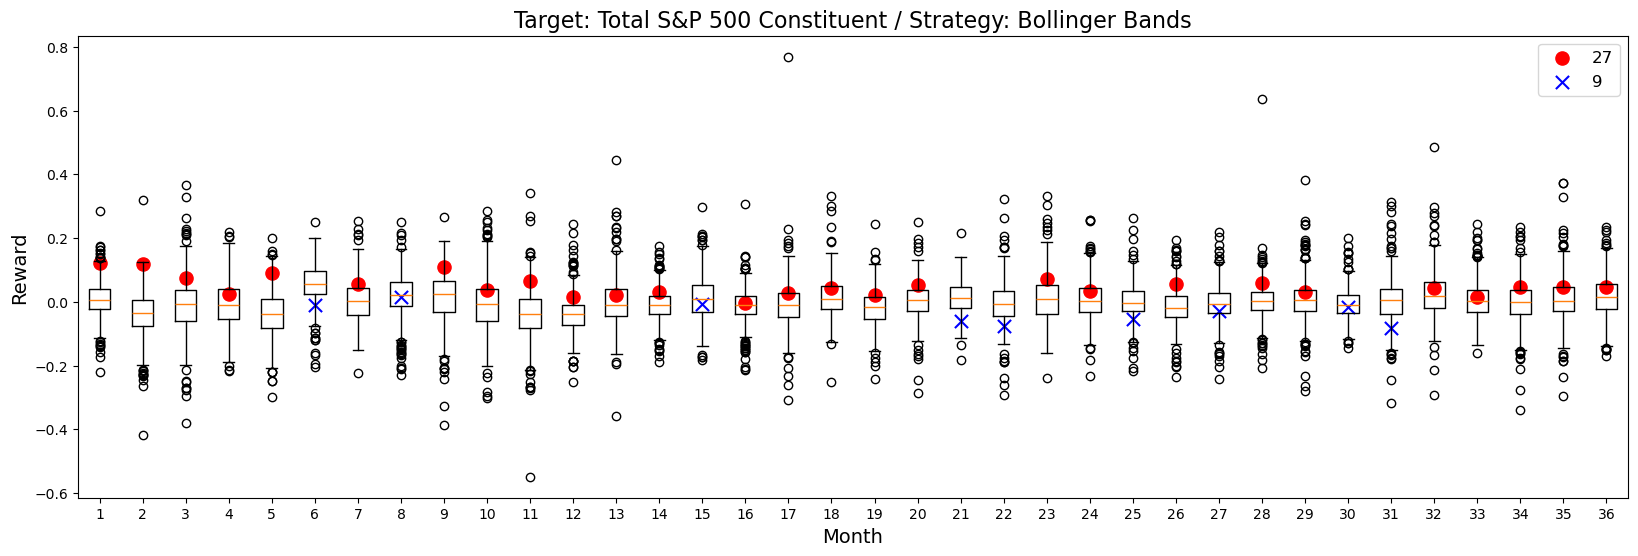

In [61]:
plt.figure(figsize=(20, 6))
plt.boxplot(single_result_total_BB_table)
plt.scatter(
    above_median_x_BB_total,
    above_median_y_BB_total,
    s=90,
    color="red",
    marker="o",
    label=f"{len(above_median_x_BB_total)}",
)
plt.scatter(
    below_median_x_BB_total,
    below_median_y_BB_total,
    s=90,
    color="blue",
    marker="x",
    label=f"{len(below_median_x_BB_total)}",
)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend(fontsize=12)
plt.title("Target: Total S&P 500 Constituent / Strategy: Bollinger Bands", fontsize=16)
plt.savefig(f"{path}/total_BB_vs_DQNPT.png", dpi=300, bbox_inches="tight")
plt.show()

### WRS test for median

In [62]:
static_pt_median = static_pt_table.median(axis=0)
single_median_total_BandH = single_result_total_BandH_table.median(axis=0)

statistic, pvalue = wilcoxon(
    static_pt_median, single_median_total_BandH, alternative="greater"
)
print(f"p-value of WRS test (Static-PT vs. Total S&P 500 (B&H) ): {pvalue: .4f}")

print("=" * 30)

statistic, pvalue = wilcoxon(
    dqn_pt_reward, single_median_total_BandH, alternative="greater"
)
print(f"p-value of WRS test (DQN-PT vs. Total S&P 500 (B&H) ): {pvalue: .4f}")

p-value of WRS test (Static-PT vs. Total S&P 500 (B&H) ):  0.0907
p-value of WRS test (DQN-PT vs. Total S&P 500 (B&H) ):  0.0427


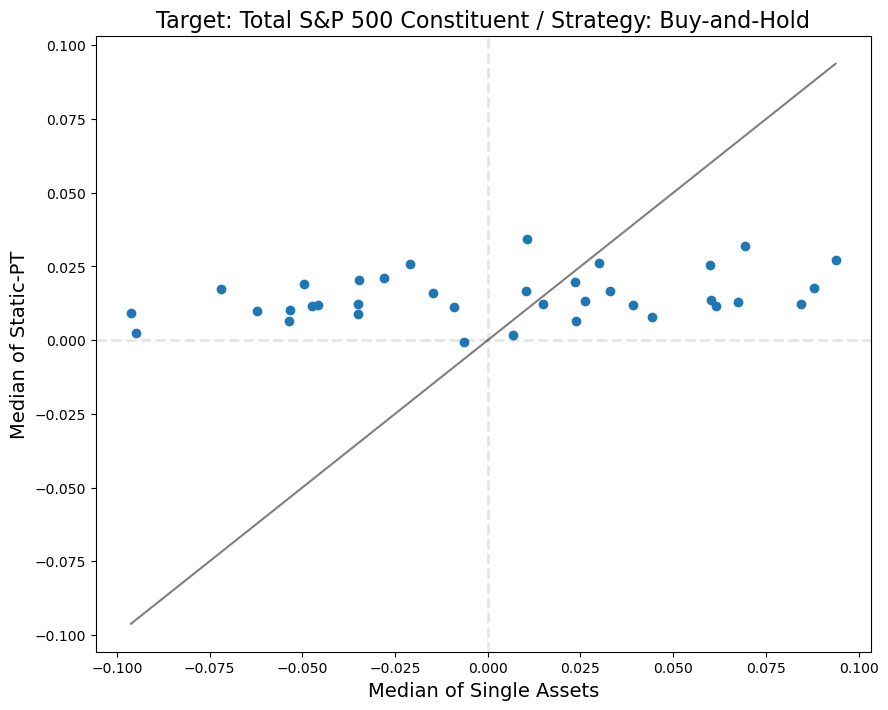

In [66]:
plt.figure(figsize=(10, 8))
plt.scatter(single_median_total_BandH, static_pt_median)
plt.plot(
    np.linspace(
        min(min(single_median_total_BandH), min(static_pt_median)),
        max(max(single_median_total_BandH), max(static_pt_median)),
        200,
    ),
    np.linspace(
        min(min(single_median_total_BandH), min(static_pt_median)),
        max(max(single_median_total_BandH), max(static_pt_median)),
        200,
    ),
    color="black",
    alpha=0.5,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Median of Single Assets", fontsize=14)
plt.ylabel("Median of Static-PT", fontsize=14)
plt.title("Target: Total S&P 500 Constituent / Strategy: Buy-and-Hold", fontsize=16)
plt.savefig(f"{path}/total_BandH_vs_StaticPT_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

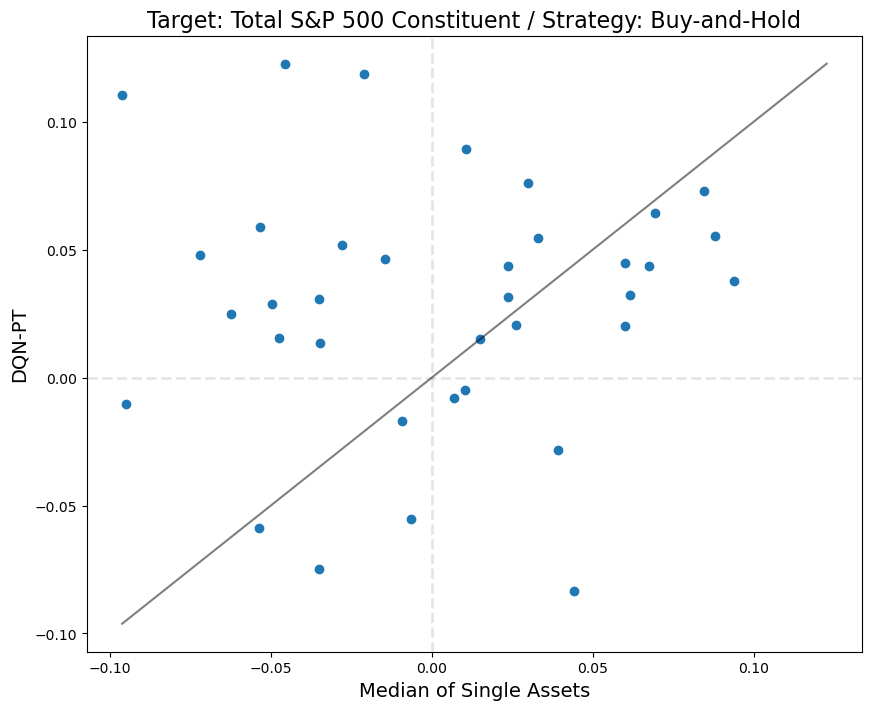

In [65]:
plt.figure(figsize=(10, 8))
plt.scatter(single_median_total_BandH, dqn_pt_reward)
plt.plot(
    np.linspace(
        min(min(single_median_total_BandH), min(dqn_pt_reward)),
        max(max(single_median_total_BandH), max(dqn_pt_reward)),
        200,
    ),
    np.linspace(
        min(min(single_median_total_BandH), min(dqn_pt_reward)),
        max(max(single_median_total_BandH), max(dqn_pt_reward)),
        200,
    ),
    color="black",
    alpha=0.5,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Median of Single Assets", fontsize=14)
plt.ylabel("DQN-PT", fontsize=14)
plt.title("Target: Total S&P 500 Constituent / Strategy: Buy-and-Hold", fontsize=16)
plt.savefig(f"{path}/total_BandH_vs_DQNPT_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

In [67]:
single_median_total_BB = single_result_total_BB_table.median(axis=0)

statistic, pvalue = wilcoxon(
    static_pt_median, single_median_total_BB, alternative="greater"
)
print(f"p-value of WRS test (Static-PT vs. Total S&P 500 (BB) ): {pvalue: .4f}")

print("=" * 30)

statistic, pvalue = wilcoxon(
    dqn_pt_reward, single_median_total_BB, alternative="greater"
)
print(f"p-value of WRS test (DQN-PT vs. Total S&P 500 (BB) ): {pvalue: .4f}")

p-value of WRS test (Static-PT vs. Total S&P 500 (BB) ):  0.0000
p-value of WRS test (DQN-PT vs. Total S&P 500 (BB) ):  0.0017


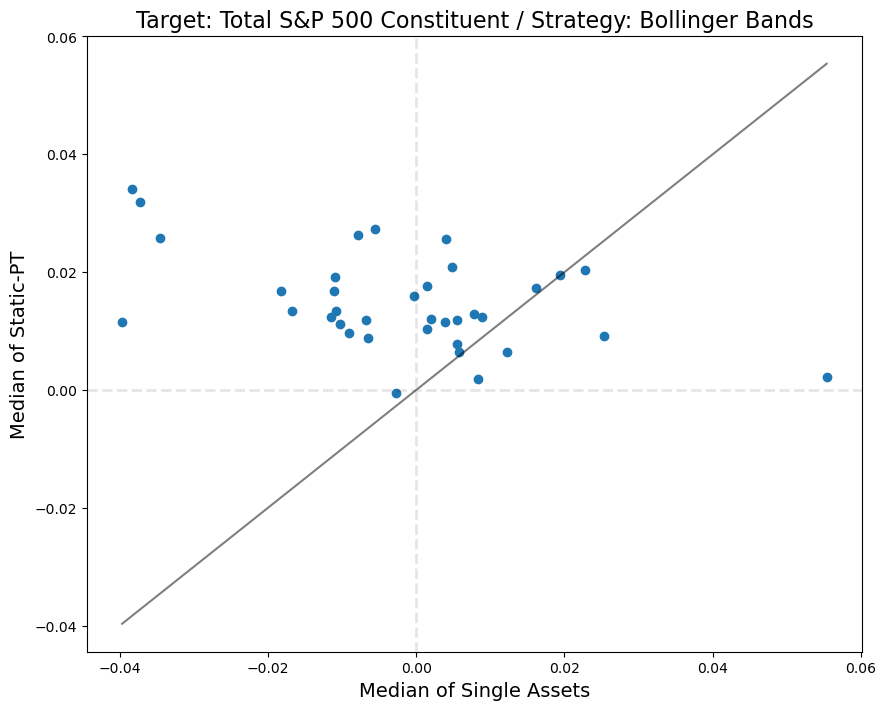

In [68]:
plt.figure(figsize=(10, 8))
plt.scatter(single_median_total_BB, static_pt_median)
plt.plot(
    np.linspace(
        min(min(single_median_total_BB), min(static_pt_median)),
        max(max(single_median_total_BB), max(static_pt_median)),
        200,
    ),
    np.linspace(
        min(min(single_median_total_BB), min(static_pt_median)),
        max(max(single_median_total_BB), max(static_pt_median)),
        200,
    ),
    color="black",
    alpha=0.5,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Median of Single Assets", fontsize=14)
plt.ylabel("Median of Static-PT", fontsize=14)
plt.title("Target: Total S&P 500 Constituent / Strategy: Bollinger Bands", fontsize=16)
plt.savefig(f"{path}/total_BB_vs_StaticPT_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

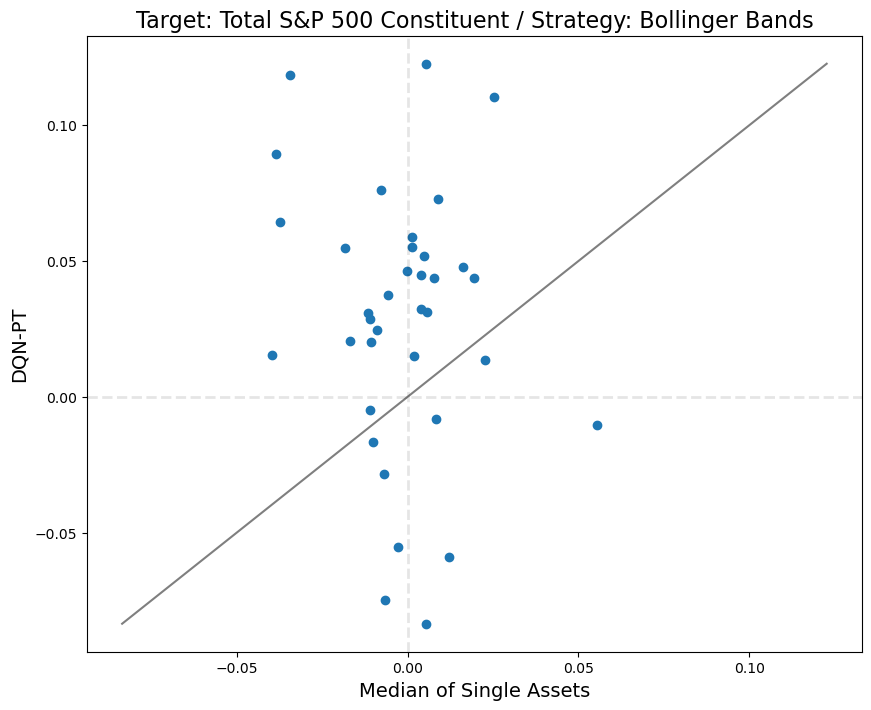

In [69]:
plt.figure(figsize=(10, 8))
plt.scatter(single_median_total_BB, dqn_pt_reward)
plt.plot(
    np.linspace(
        min(min(single_median_total_BB), min(dqn_pt_reward)),
        max(max(single_median_total_BB), max(dqn_pt_reward)),
        200,
    ),
    np.linspace(
        min(min(single_median_total_BB), min(dqn_pt_reward)),
        max(max(single_median_total_BB), max(dqn_pt_reward)),
        200,
    ),
    color="black",
    alpha=0.5,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Median of Single Assets", fontsize=14)
plt.ylabel("DQN-PT", fontsize=14)
plt.title("Target: Total S&P 500 Constituent / Strategy: Bollinger Bands", fontsize=16)
plt.savefig(f"{path}/total_BB_vs_DQNPT_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

## Comparison Target: Static Pairs Trading

### Boxplot for rewards

In [70]:
above_median_x_pt, above_median_y_pt = [], []
below_median_x_pt, below_median_y_pt = [], []

for x, y in enumerate(static_pt_table.median()):
    value = dqn_pt_reward[x]

    if value > y:
        above_median_x_pt.append(x + 1)
        above_median_y_pt.append(value)

    else:
        below_median_x_pt.append(x + 1)
        below_median_y_pt.append(value)

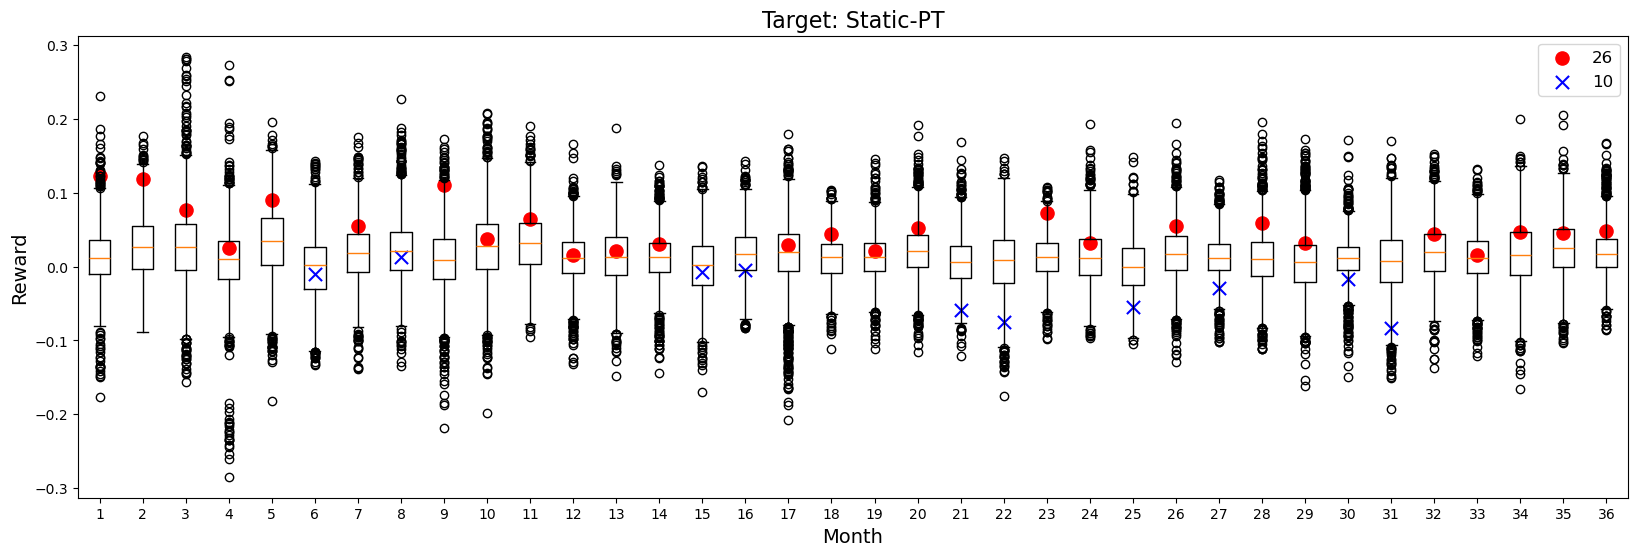

In [75]:
plt.figure(figsize=(20, 6))
plt.boxplot(static_pt_table)
plt.scatter(
    above_median_x_pt,
    above_median_y_pt,
    s=90,
    color="red",
    marker="o",
    label=f"{len(above_median_x_pt)}",
)
plt.scatter(
    below_median_x_pt,
    below_median_y_pt,
    s=90,
    color="blue",
    marker="x",
    label=f"{len(below_median_x_pt)}",
)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend(fontsize=12)
plt.title("Target: Static-PT", fontsize=16)
plt.savefig(f"{path}/StaticPT_vs_DQNPT.png", dpi=300, bbox_inches="tight")
plt.show()

### WRS test for median

In [72]:
statistic, pvalue = wilcoxon(
    dqn_pt_reward, static_pt_median, alternative="greater"
)
print(f"p-value of WRS test: {pvalue: .4f}")

p-value of WRS test:  0.0174


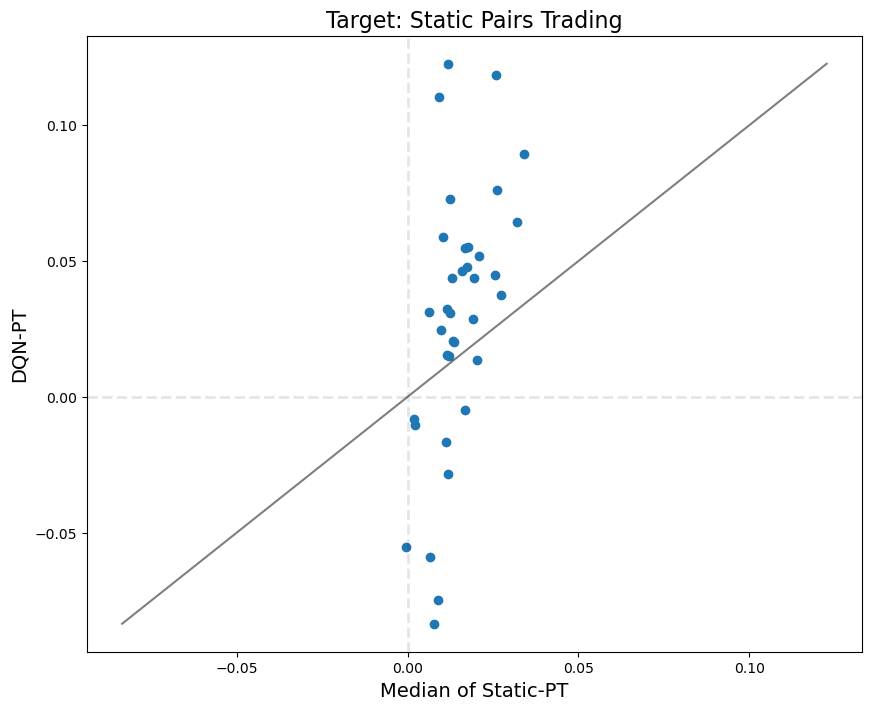

In [74]:
plt.figure(figsize=(10, 8))
plt.scatter(static_pt_median, dqn_pt_reward)
plt.plot(
    np.linspace(
        min(min(static_pt_median), min(dqn_pt_reward)),
        max(max(static_pt_median), max(dqn_pt_reward)),
        200,
    ),
    np.linspace(
        min(min(static_pt_median), min(dqn_pt_reward)),
        max(max(static_pt_median), max(dqn_pt_reward)),
        200,
    ),
    color="black",
    alpha=0.5,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Median of Static-PT", fontsize=14)
plt.ylabel("DQN-PT", fontsize=14)
plt.title("Target: Static Pairs Trading", fontsize=16)
plt.savefig(f"{path}/StaticPT_vs_DQNPT_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

## Comparison Target: Tangency Portfolio from Reduced S&P 500 Constituent

In [ ]:
train_data_reduced = pd.read_csv("data_file/train_PT.csv", encoding="UTF-8")
tickers_reduced = train_data_reduced["Ticker"].unique()

In [77]:
train_reduced_table = {}

for ticker in tickers_reduced:
    target = train_data_reduced[train_data_reduced["Ticker"] == ticker].copy()
    temp_result = np.log(target["Close"] / target["Close"].shift(1))
    train_reduced_table[ticker] = temp_result.dropna().values

train_reduced_table = pd.DataFrame(train_reduced_table)
train_reduced_table_mu = train_reduced_table.mean().values
train_reduced_table_cov = train_reduced_table.cov().values

In [78]:
def neg_sharpe_ratio(weights, mu, cov):
    portfolio_return = np.dot(weights, mu)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))

    return -portfolio_return / portfolio_volatility


def tangency_portfolio(mu, cov):
    num_assets = len(mu)
    initial_weights = np.ones(num_assets) / num_assets
    # bounds = [(-np.inf, np.inf) for _ in range(num_assets)]
    bounds = [(0, 1) for _ in range(num_assets)]
    constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
    result = minimize(
        neg_sharpe_ratio,
        initial_weights,
        args=(mu, cov),
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
    )
    
    return result.x

In [79]:
test_data_reduced = pd.read_csv("data_file/test_PT.csv", encoding="UTF-8")
tickers_reduced = test_data_reduced["Ticker"].unique()

# Add daily log return and Bollinger bands to the original stock price data
append_value_reduced = []

for ticker in tickers_reduced:
    target = test_data_reduced[test_data_reduced["Ticker"] == ticker].copy()
    target["ma_line"] = target["Close"].rolling(window=5).mean()
    std = target["Close"].rolling(window=5).std()
    target["upper_bound"] = target["ma_line"] + 1 * std
    target["lower_bound"] = target["ma_line"] - 1 * std

    target["log_return"] = np.log(target["Close"] / target["Close"].shift(1))

    target = target.dropna()
    append_value_reduced.append(target)

test_append_reduced = pd.concat(append_value_reduced, ignore_index=True)

In [81]:
test_append_reduced_table = pd.DataFrame(
    {
        ticker: test_append_reduced[test_append_reduced["Ticker"] == ticker]["log_return"].values
        for ticker in tickers_reduced
    }
)

test_append_reduced_returns = [
    np.dot(
        tangency_portfolio(train_reduced_table_mu, train_reduced_table_cov),
        test_append_reduced_table.iloc[x, :].values,
    )
    for x in range(test_append_reduced_table.shape[0])
]

In [82]:
temp = test_append_reduced[test_append_reduced["Ticker"] == "AMCR"]
temp["weighted_logrtn"] = test_append_reduced_returns

portfolio_result_reduced_BandH = []

for year in temp["Year"].unique():
    for month in temp["Month"].unique():
        mask_table = temp[(temp["Year"] == year) & (temp["Month"] == month)]
        portfolio_result_reduced_BandH.append(mask_table["weighted_logrtn"].sum())

### WRS test

In [84]:
statistic, pvalue = wilcoxon(
    dqn_pt_reward, portfolio_result_reduced_BandH, alternative="greater"
)
print(f"p-value of WRS test: {pvalue: .4f}")

p-value of WRS test:  0.0739


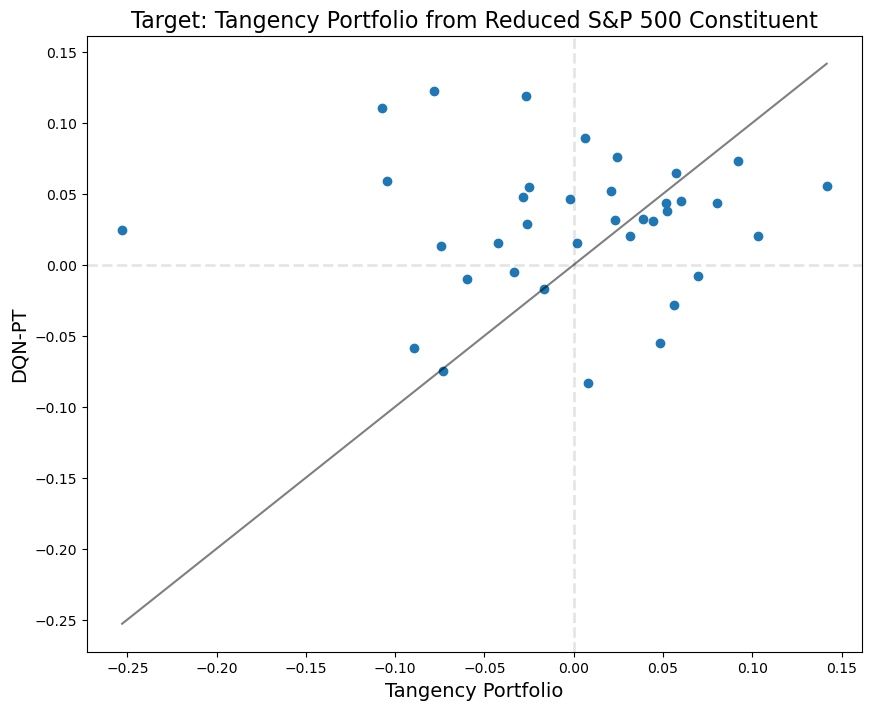

In [85]:
plt.figure(figsize=(10, 8))
plt.scatter(portfolio_result_reduced_BandH, dqn_pt_reward)
plt.plot(
    np.linspace(
        min(min(portfolio_result_reduced_BandH), min(dqn_pt_reward)),
        max(max(portfolio_result_reduced_BandH), max(dqn_pt_reward)),
        200,
    ),
    np.linspace(
        min(min(portfolio_result_reduced_BandH), min(dqn_pt_reward)),
        max(max(portfolio_result_reduced_BandH), max(dqn_pt_reward)),
        200,
    ),
    color="black",
    alpha=0.5,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Tangency Portfolio", fontsize=14)
plt.ylabel("DQN-PT", fontsize=14)
plt.title("Target: Tangency Portfolio from Reduced S&P 500 Constituent", fontsize=16)
plt.savefig(f"{path}/port_reduced_vs_DQNPT_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

## Comparison Target: Tangency Portfolio from Total S&P 500 Constituent

In [86]:
train_data_total = pd.read_csv("data_file/train.csv", encoding="UTF-8")
tickers_total = train_data_total["Ticker"].unique()

In [87]:
train_total_table = {}

for ticker in tickers_total:
    target = train_data_total[train_data_total["Ticker"] == ticker].copy()
    temp_result = np.log(target["Close"] / target["Close"].shift(1))
    train_total_table[ticker] = temp_result.dropna().values

train_total_table = pd.DataFrame(train_total_table)
train_total_table_mu = train_total_table.mean().values
train_total_table_cov = train_total_table.cov().values

In [88]:
test_data_total = pd.read_csv("data_file/test.csv", encoding="UTF-8")
tickers_total = test_data_total["Ticker"].unique()

# Add daily log return and Bollinger bands to the original stock price data
append_value_total = []

for ticker in tickers_total:
    target = test_data_total[test_data_total["Ticker"] == ticker].copy()
    target["ma_line"] = target["Close"].rolling(window=5).mean()
    std = target["Close"].rolling(window=5).std()
    target["upper_bound"] = target["ma_line"] + 1 * std
    target["lower_bound"] = target["ma_line"] - 1 * std

    target["log_return"] = np.log(target["Close"] / target["Close"].shift(1))

    target = target.dropna()
    append_value_total.append(target)

test_append_total = pd.concat(append_value_total, ignore_index=True)

## Cumulative Reward Plot

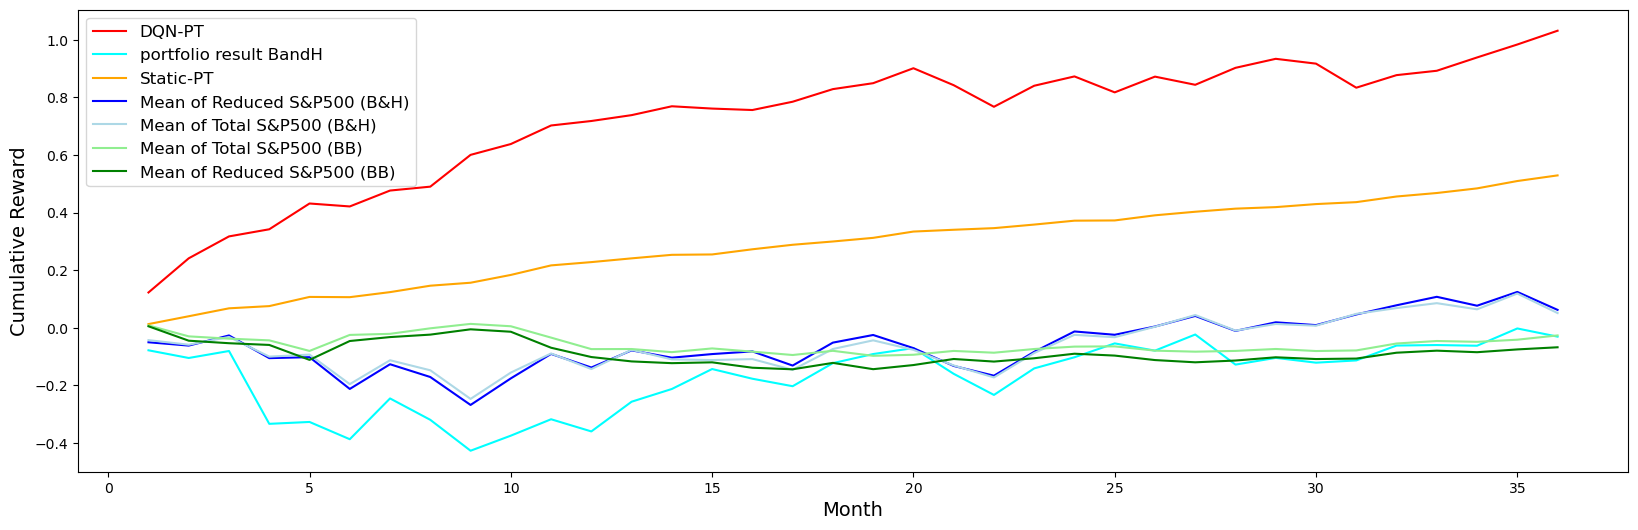

In [57]:
static_pairs_mean = static_pairs_table.mean(axis=0)
single_mean_BandH = single_result_BandH_table.mean(axis=0)
single_mean_BB = single_result_BB_table.mean(axis=0)
single_mean_total_BandH = single_result_total_BandH_table.mean(axis=0)
single_mean_total_BB = single_result_total_BB_table.mean(axis=0)
portfolio_result_BandH = np.array(portfolio_result_BandH)

dqn_result_cum_reward = []

for i in range(len(dqn_result_reward)):
    dqn_result_cum_reward.append(sum(dqn_result_reward[: i + 1]))

plt.figure(figsize=(20, 6))
plt.plot(range(1, 37), dqn_result_cum_reward, color="red", label="DQN-PT")
plt.plot(
    range(1, 37),
    portfolio_result_BandH.cumsum(),
    color="cyan",
    label="portfolio result BandH",
)
plt.plot(range(1, 37), static_pairs_mean.cumsum(), color="orange", label="Static-PT")
plt.plot(
    range(1, 37),
    single_mean_BandH.cumsum(),
    color="blue",
    label="Mean of Reduced S&P500 (B&H)",
)
plt.plot(
    range(1, 37),
    single_mean_total_BandH.cumsum(),
    color="lightblue",
    label="Mean of Total S&P500 (B&H)",
)
plt.plot(
    range(1, 37),
    single_mean_total_BB.cumsum(),
    color="lightgreen",
    label="Mean of Total S&P500 (BB)",
)
plt.plot(
    range(1, 37),
    single_mean_BB.cumsum(),
    color="green",
    label="Mean of Reduced S&P500 (BB)",
)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Cumulative Reward", fontsize=14)
plt.legend(fontsize=12)
# plt.title("Target: Reduced S&P500 Constituent", fontsize=16)
plt.show()

## Performance Indicators

In [58]:
print(f"Mean Return: {mean_return(dqn_result_reward) * 100: .3f}")
print(f"Sharpe Ratio: {sharpe_ratio(dqn_result_reward): .3f}")
print(f"Sortino Ratio: {sortino_ratio(dqn_result_reward): .3f}")
print(f"Profit Factor: {profit_factor(dqn_result_reward): .3f}")
print(f"Calmar Ratio: {calmar_ratio(dqn_result_reward): .3f}")
print(f"Max Drawdown: {max_drawdown(dqn_result_reward): .3f}")

Mean Return:  34.389
Sharpe Ratio:  2.040
Sortino Ratio:  3.443
Profit Factor:  4.024
Calmar Ratio:  2.657
Max Drawdown: -0.129


In [59]:
print(
    f"Mean Return: {np.mean([mean_return(static_pairs_table.iloc[x, :]) for x in range(len(static_pairs_table))]) * 100: .3f}"
)
print(
    f"Sharpe Ratio: {np.mean([sharpe_ratio(static_pairs_table.iloc[x, :]) for x in range(len(static_pairs_table))]): .3f}"
)
print(
    f"Sortino Ratio: {np.mean([sortino_ratio(static_pairs_table.iloc[x, :]) for x in range(len(static_pairs_table))]): .3f}"
)
print(
    f"Profit Factor: {np.mean([profit_factor(static_pairs_table.iloc[x, :]) for x in range(len(static_pairs_table))]): .3f}"
)
print(
    f"Calmar Ratio: {np.mean([calmar_ratio(static_pairs_table.iloc[x, :]) for x in range(len(static_pairs_table))]): .3f}"
)
print(
    f"Max Drawdown: {np.mean([max_drawdown(static_pairs_table.iloc[x, :]) for x in range(len(static_pairs_table))]): .3f}"
)

Mean Return:  17.642
Sharpe Ratio:  1.306
Sortino Ratio:  2.643
Profit Factor:  3.006
Calmar Ratio:  1.943
Max Drawdown: -0.125


In [60]:
print(
    f"Mean Return: {np.mean([mean_return(single_result_BB_table.iloc[x, :]) for x in range(len(single_result_BB_table))]) * 100: .3f}"
)
print(
    f"Sharpe Ratio: {np.mean([sharpe_ratio(single_result_BB_table.iloc[x, :]) for x in range(len(single_result_BB_table))]): .3f}"
)
print(
    f"Sortino Ratio: {np.mean([sortino_ratio(single_result_BB_table.iloc[x, :]) for x in range(len(single_result_BB_table))]): .3f}"
)
print(
    f"Profit Factor: {np.mean([profit_factor(single_result_BB_table.iloc[x, :]) for x in range(len(single_result_BB_table))]): .3f}"
)
print(
    f"Calmar Ratio: {np.mean([calmar_ratio(single_result_BB_table.iloc[x, :]) for x in range(len(single_result_BB_table))]): .3f}"
)
print(
    f"Max Drawdown: {np.mean([max_drawdown(single_result_BB_table.iloc[x, :]) for x in range(len(single_result_BB_table))]): .3f}"
)

Mean Return: -2.255
Sharpe Ratio: -0.057
Sortino Ratio: -0.035
Profit Factor:  1.031
Calmar Ratio:  0.042
Max Drawdown: -0.381


In [61]:
print(
    f"Mean Return: {np.mean([mean_return(single_result_total_BB_table.iloc[x, :]) for x in range(len(single_result_total_BB_table))]) * 100: .3f}"
)
print(
    f"Sharpe Ratio: {np.mean([sharpe_ratio(single_result_total_BB_table.iloc[x, :]) for x in range(len(single_result_total_BB_table))]): .3f}"
)
print(
    f"Sortino Ratio: {np.mean([sortino_ratio(single_result_total_BB_table.iloc[x, :]) for x in range(len(single_result_total_BB_table))]): .3f}"
)
print(
    f"Profit Factor: {np.mean([profit_factor(single_result_total_BB_table.iloc[x, :]) for x in range(len(single_result_total_BB_table))]): .3f}"
)
print(
    f"Calmar Ratio: {np.mean([calmar_ratio(single_result_total_BB_table.iloc[x, :]) for x in range(len(single_result_total_BB_table))]): .3f}"
)
print(
    f"Max Drawdown: {np.mean([max_drawdown(single_result_total_BB_table.iloc[x, :]) for x in range(len(single_result_total_BB_table))]): .3f}"
)

Mean Return: -0.882
Sharpe Ratio: -0.041
Sortino Ratio:  0.017
Profit Factor:  1.071
Calmar Ratio:  0.112
Max Drawdown: -0.355


In [62]:
print(
    f"Mean Return: {np.mean([mean_return(single_result_BandH_table.iloc[x, :]) for x in range(len(single_result_BandH_table))]) * 100: .3f}"
)
print(
    f"Sharpe Ratio: {np.mean([sharpe_ratio(single_result_BandH_table.iloc[x, :]) for x in range(len(single_result_BandH_table))]): .3f}"
)
print(
    f"Sortino Ratio: {np.mean([sortino_ratio(single_result_BandH_table.iloc[x, :]) for x in range(len(single_result_BandH_table))]): .3f}"
)
print(
    f"Profit Factor: {np.mean([profit_factor(single_result_BandH_table.iloc[x, :]) for x in range(len(single_result_BandH_table))]): .3f}"
)
print(
    f"Calmar Ratio: {np.mean([calmar_ratio(single_result_BandH_table.iloc[x, :]) for x in range(len(single_result_BandH_table))]): .3f}"
)
print(
    f"Max Drawdown: {np.mean([max_drawdown(single_result_BandH_table.iloc[x, :]) for x in range(len(single_result_BandH_table))]): .3f}"
)

Mean Return:  2.074
Sharpe Ratio:  0.074
Sortino Ratio:  0.140
Profit Factor:  1.123
Calmar Ratio:  0.146
Max Drawdown: -0.371


In [63]:
print(
    f"Mean Return: {np.mean([mean_return(single_result_total_BandH_table.iloc[x, :]) for x in range(len(single_result_total_BandH_table))]) * 100: .3f}"
)
print(
    f"Sharpe Ratio: {np.mean([sharpe_ratio(single_result_total_BandH_table.iloc[x, :]) for x in range(len(single_result_total_BandH_table))]): .3f}"
)
print(
    f"Sortino Ratio: {np.mean([sortino_ratio(single_result_total_BandH_table.iloc[x, :]) for x in range(len(single_result_total_BandH_table))]): .3f}"
)
print(
    f"Profit Factor: {np.mean([profit_factor(single_result_total_BandH_table.iloc[x, :]) for x in range(len(single_result_total_BandH_table))]): .3f}"
)
print(
    f"Calmar Ratio: {np.mean([calmar_ratio(single_result_total_BandH_table.iloc[x, :]) for x in range(len(single_result_total_BandH_table))]): .3f}"
)
print(
    f"Max Drawdown: {np.mean([max_drawdown(single_result_total_BandH_table.iloc[x, :]) for x in range(len(single_result_total_BandH_table))]): .3f}"
)

Mean Return:  1.705
Sharpe Ratio:  0.085
Sortino Ratio:  0.190
Profit Factor:  1.130
Calmar Ratio:  0.167
Max Drawdown: -0.373
